In [86]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [103]:
!pip install skorch pyfaidx

In [105]:
!wget -O /content/hg38.fa.gz http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
!gunzip /content/hg38.fa.gz
import os
if os.path.exists('/content/hg38.fa'):
    file_size = os.path.getsize('/content/hg38.fa') / (1024**3)  # Size in GB
    print(f"hg38.fa downloaded successfully!")
    print(f"File size: {file_size:.2f} GB")
    print(f"Path: /content/hg38.fa")
else:
    print("Download failed!")

--2025-10-28 21:03:48--  http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘/content/hg38.fa.gz’

/content/hg38.fa.gz 100%[===================>] 938.09M  18.0MB/s    in 61s     

2025-10-28 21:04:50 (15.3 MB/s) - ‘/content/hg38.fa.gz’ saved [983659424/983659424]

hg38.fa downloaded successfully!
File size: 3.05 GB
Path: /content/hg38.fa


In [118]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pyfaidx import Fasta
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint
from skorch.callbacks import EarlyStopping
from skorch.callbacks import EpochScoring
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset
from torch.utils.data import Subset
from typing import TypedDict
from dataclasses import dataclass, field
from pathlib import Path
import matplotlib.pyplot as plt
from enum import Enum
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from skorch.callbacks import Callback
from tqdm.notebook import tqdm

## Work Package 1.1 - Modeling Choices & Data Pre-processing

In [119]:
# TODO:
# Load your feature (bed and/or bigwig and/or fasta) and target files (tsv) here.
# Decide which features to use for training. Feel free to process them however you need.

# NOTE:
# bed and bigwig files contain signals of all chromosomes (including sex chromosomes).
# Training and validation split based on chromosomes has been done for you.
# However, you can resplit the data in any way you want.

# ---------------------------INSERT CODE HERE---------------------------
WINDOW_SIZE = 196_608
BIN_SIZE = 128
SAMPLE_N = None  # Set to e.g., 100 for quick testing, None for full dataset


# cell_line_x1, cell_line_x2, cell_line_x3 = process_all_cell_lines(
#     data_path="/workspaces/Gene-Expression-Prediction/data",
#     window_size=WINDOW_SIZE,
#     bin_size=BIN_SIZE,
#     sample_n=SAMPLE_N,
#     save_to_disk=True,
#     output_dir=DATA_PATH,
# )

class SingleGeneData(TypedDict):
    """A dictionary holding all processed data for a single gene."""

    gene_info: pd.Series
    sequence_tensor_slice: np.ndarray
    target: float | None


@dataclass
class ProcessedFeatures:
    """
    Holds all processed data for a cell line using uniform binning.

    Following Enformer's approach:
    - Uniform 128bp bins across the entire window
    - Window centered on TSS (typically ±100kb)
    - Simple, consistent data structure

    Attributes:
        gene_annotations: Gene metadata (n_genes, n_annotation_columns)
        sequence_signal_tensor: Chromatin features (n_genes, n_bins, n_features)
        window_size: Total genomic window size in bp (e.g., 200000 for ±100kb)
        bin_size: Size of each bin in bp (typically 128)
        n_bins: Total number of bins
        target_expression: Gene expression targets (n_genes,)
        has_dna_features: Whether DNA features are included (False = 7 features, True = 13 features)
        raw_dna_sequences: Raw DNA sequences for debugging (n_genes,) - optional
    """
    gene_annotations: pd.DataFrame
    sequence_signal_tensor: np.ndarray
    window_size: int
    bin_size: int
    n_bins: int
    target_expression: pd.Series | None
    has_dna_features: bool = False
    raw_dna_sequences: np.ndarray | None = None

    def get_gene_data_by_index(self, index: int) -> SingleGeneData:
        """Retrieves all data for a single gene at a specific integer index."""
        if not (0 <= index < len(self.gene_annotations)):
            raise IndexError(
                f"Index {index} is out of bounds (0-{len(self.gene_annotations) - 1})."
            )

        gene_name = self.gene_annotations.iloc[index]["gene_name"]

        return {
            "gene_info": self.gene_annotations.iloc[index],
            "sequence_tensor_slice": self.sequence_signal_tensor[index],
            "target": self.target_expression.loc[gene_name]
            if self.target_expression is not None
            else None,
        }

    def get_gene_data_by_name(self, gene_name: str) -> SingleGeneData:
        """Retrieves all data for a single gene by its unique name."""
        matches = self.gene_annotations.index[
            self.gene_annotations["gene_name"] == gene_name
        ].tolist()
        if not matches:
            raise KeyError(f"Gene '{gene_name}' not found in annotations.")

        index = matches[0]
        return self.get_gene_data_by_index(index)

    @property
    def half_window_size(self) -> int:
        """Returns the distance from TSS to window edge (±distance)."""
        return self.window_size // 2


def load_processed_features(directory_path: str | Path) -> ProcessedFeatures:
    """
    Loads ProcessedFeatures from disk.

    Args:
        directory_path: Directory containing the saved files

    Returns:
        Reconstructed ProcessedFeatures object
    """
    path = Path(directory_path)
    if not path.is_dir():
        raise FileNotFoundError(f"Directory not found: {path}")

    annotations = pd.read_parquet(path / "gene_annotations.parquet")
    signal_tensor = np.load(path / "sequence_signal_tensor.npy")
    config = np.load(path / "config.npy", allow_pickle=True).item()

    targets = None
    target_path = path / "target_expression.csv"
    if target_path.exists():
        targets = pd.read_csv(target_path, index_col=0, header=0).squeeze("columns")

    print(f"Loaded processed features from: {path}")

    return ProcessedFeatures(
        gene_annotations=annotations,
        sequence_signal_tensor=signal_tensor,
        window_size=config["window_size"],
        bin_size=config["bin_size"],
        n_bins=config["n_bins"],
        target_expression=targets,
    )

cell_line_x1 = load_processed_features(
    "/content/gdrive/MyDrive/processed_data_x1_enformer"
)
cell_line_x2 = load_processed_features(
    "/content/gdrive/MyDrive/processed_data_x2_enformer"
)
cell_line_x3 = load_processed_features(
    "/content/gdrive/MyDrive/processed_data_x3_enformer"
)
# ----------------------------------------------------------------------

Loaded processed features from: /content/gdrive/MyDrive/processed_data_x1_enformer
Loaded processed features from: /content/gdrive/MyDrive/processed_data_x2_enformer
Loaded processed features from: /content/gdrive/MyDrive/processed_data_x3_enformer


In [120]:
# genome = Fasta('/content/hg38.fa')

# class DNAFeatureExtractor:
#     """Extract DNA composition features per bin."""

#     def __init__(self, genome: Fasta):
#         self.genome = genome

#     def reverse_complement(self, seq: str) -> str:
#         """Reverse complement a DNA sequence."""
#         complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C', 'N': 'N'}
#         return ''.join(complement.get(base, 'N') for base in reversed(seq))

#     def extract_sequence(
#         self,
#         chrom: str,
#         start: int,
#         end: int,
#         strand: str
#     ) -> str:
#         """Extract DNA sequence from genomic coordinates."""
#         if not chrom.startswith('chr'):
#             chrom = f'chr{chrom}'

#         seq = str(self.genome[chrom][start:end]).upper()

#         if strand == '-':
#             seq = self.reverse_complement(seq)

#         return seq

#     def compute_features_per_bin(
#         self,
#         seq: str,
#         n_bins: int
#     ) -> np.ndarray:
#         """
#         Compute 6 DNA features per bin.

#         Args:
#             seq: DNA sequence (length = n_bins * bin_size)
#             n_bins: Number of bins

#         Returns:
#             Array of shape (6, n_bins) with features:
#             [%A, %C, %G, %T, GC%, CpG density]
#         """
#         bin_size = len(seq) // n_bins
#         features = []

#         for i in range(n_bins):
#             start = i * bin_size
#             end = start + bin_size
#             bin_seq = seq[start:end]

#             total = len(bin_seq)
#             count_a = bin_seq.count('A')
#             count_c = bin_seq.count('C')
#             count_g = bin_seq.count('G')
#             count_t = bin_seq.count('T')

#             if total == 0 or (count_a + count_c + count_g + count_t) == 0:
#                 bin_features = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
#             else:
#                 freq_a = count_a / total
#                 freq_c = count_c / total
#                 freq_g = count_g / total
#                 freq_t = count_t / total

#                 gc_content = (count_g + count_c) / total

#                 cpg_count = bin_seq.count('CG')
#                 cpg_density = cpg_count / (total - 1) if total > 1 else 0.0

#                 bin_features = [
#                     freq_a,
#                     freq_c,
#                     freq_g,
#                     freq_t,
#                     gc_content,
#                     cpg_density
#                 ]

#             features.append(bin_features)

#         return np.array(features, dtype=np.float32).T


# def add_dna_features_to_cell_line(
#     cell_line: ProcessedFeatures,
#     extractor: DNAFeatureExtractor,
#     n_bins: int,
#     bin_size: int
# ) -> tuple[np.ndarray, np.ndarray]:
#     """
#     Extract DNA features for all genes in a cell line.

#     Args:
#         cell_line: ProcessedFeatures object
#         extractor: DNAFeatureExtractor instance
#         n_bins: Number of bins to use (should match your model)
#         bin_size: Size of each bin in bp

#     Returns:
#         Tuple of (dna_features, raw_sequences)
#         - dna_features: array of shape (n_genes, 6, n_bins)
#         - raw_sequences: array of strings (n_genes,) containing raw DNA sequences
#     """
#     n_genes = len(cell_line.gene_annotations)
#     dna_features = np.zeros((n_genes, 6, n_bins), dtype=np.float32)
#     raw_sequences = np.empty(n_genes, dtype=object)

#     window_size = n_bins * bin_size
#     half_window = window_size // 2

#     failed_genes = []

#     for idx, gene_row in tqdm(
#         cell_line.gene_annotations.iterrows(),
#         total=n_genes,
#         desc="Extracting DNA features"
#     ):
#         try:
#             chrom = gene_row['chr']
#             tss = int(gene_row['TSS_start'])
#             strand = gene_row['strand']

#             start = tss - half_window
#             end = tss + half_window

#             # Extract sequence
#             seq = extractor.extract_sequence(chrom, start, end, strand)
#             raw_sequences[idx] = seq  # Store raw sequence

#             # Compute features
#             features = extractor.compute_features_per_bin(seq, n_bins)
#             dna_features[idx] = features

#         except Exception as e:
#             failed_genes.append((gene_row['gene_name'], str(e)))
#             raw_sequences[idx] = ""  # Empty string for failed genes
#             continue

#     if failed_genes:
#         print(f"\n⚠ Warning: {len(failed_genes)} genes failed DNA extraction")
#         print(f"First few failures: {failed_genes[:3]}")

#     print(f"\n✓ Successfully extracted DNA features for {n_genes - len(failed_genes)}/{n_genes} genes")
#     print(f"DNA features shape: {dna_features.shape}")

#     return dna_features, raw_sequences


# def combine_histone_and_dna_features(
#     histone_features: np.ndarray,
#     dna_features: np.ndarray,
#     n_bins: int
# ) -> np.ndarray:
#     """
#     Combine histone and DNA features.

#     Args:
#         histone_features: Shape (n_genes, original_bins, 7)
#         dna_features: Shape (n_genes, 6, n_bins)
#         n_bins: Number of bins to use

#     Returns:
#         Combined features of shape (n_genes, n_bins, 13)
#         [7 histone features + 6 DNA features]
#     """
#     n_genes = histone_features.shape[0]
#     original_bins = histone_features.shape[1]

#     if original_bins != n_bins:
#         start_idx = (original_bins - n_bins) // 2
#         end_idx = start_idx + n_bins
#         histone_cropped = histone_features[:, start_idx:end_idx, :]
#         print(f"Center-cropped histone from {original_bins} to {n_bins} bins")
#     else:
#         histone_cropped = histone_features

#     histone_transposed = histone_cropped.transpose(0, 2, 1)
#     combined = np.concatenate([histone_transposed, dna_features], axis=1)
#     combined = combined.transpose(0, 2, 1)

#     print(f"\n✓ Combined features shape: {combined.shape}")
#     print(f"  - Histone features: 7")
#     print(f"  - DNA features: 6")
#     print(f"  - Total features: 13")

#     return combined


# print("=" * 70)
# print("ADDING DNA FEATURES TO ALL CELL LINES")
# print("=" * 70)

# extractor = DNAFeatureExtractor(genome)
# N_BINS = cell_line_x1.n_bins
# BIN_SIZE = cell_line_x1.bin_size

# print(f"\nProcessing with {N_BINS} bins ({N_BINS * BIN_SIZE}bp window)")

# print("\n" + "=" * 70)
# print("Processing Cell Line X1...")
# print("=" * 70)
# dna_x1, raw_seq_x1 = add_dna_features_to_cell_line(
#     cell_line_x1, extractor, n_bins=N_BINS, bin_size=BIN_SIZE
# )
# combined_x1 = combine_histone_and_dna_features(
#     cell_line_x1.sequence_signal_tensor,
#     dna_x1,
#     n_bins=N_BINS
# )

# print("\n" + "=" * 70)
# print("Processing Cell Line X2...")
# print("=" * 70)
# dna_x2, raw_seq_x2 = add_dna_features_to_cell_line(
#     cell_line_x2, extractor, n_bins=N_BINS, bin_size=BIN_SIZE
# )
# combined_x2 = combine_histone_and_dna_features(
#     cell_line_x2.sequence_signal_tensor,
#     dna_x2,
#     n_bins=N_BINS
# )

# print("\n" + "=" * 70)
# print("Processing Cell Line X3...")
# print("=" * 70)
# dna_x3, raw_seq_x3 = add_dna_features_to_cell_line(
#     cell_line_x3, extractor, n_bins=N_BINS, bin_size=BIN_SIZE
# )
# combined_x3 = combine_histone_and_dna_features(
#     cell_line_x3.sequence_signal_tensor,
#     dna_x3,
#     n_bins=N_BINS
# )

# print("\n" + "=" * 70)
# print("✓ ALL CELL LINES PROCESSED!")
# print("=" * 70)

# cell_line_x1 = ProcessedFeatures(
#     gene_annotations=cell_line_x1.gene_annotations,
#     sequence_signal_tensor=combined_x1,
#     window_size=N_BINS * BIN_SIZE,
#     bin_size=BIN_SIZE,
#     n_bins=N_BINS,
#     target_expression=cell_line_x1.target_expression,
#     has_dna_features=True,
#     raw_dna_sequences=raw_seq_x1
# )

# cell_line_x2 = ProcessedFeatures(
#     gene_annotations=cell_line_x2.gene_annotations,
#     sequence_signal_tensor=combined_x2,
#     window_size=N_BINS * BIN_SIZE,
#     bin_size=BIN_SIZE,
#     n_bins=N_BINS,
#     target_expression=cell_line_x2.target_expression,
#     has_dna_features=True,
#     raw_dna_sequences=raw_seq_x2
# )

# cell_line_x3 = ProcessedFeatures(
#     gene_annotations=cell_line_x3.gene_annotations,
#     sequence_signal_tensor=combined_x3,
#     window_size=N_BINS * BIN_SIZE,
#     bin_size=BIN_SIZE,
#     n_bins=N_BINS,
#     target_expression=cell_line_x3.target_expression,
#     has_dna_features=True,
#     raw_dna_sequences=raw_seq_x3
# )

# print("\n✓ Updated cell_line_x1, cell_line_x2, cell_line_x3 with DNA features!")
# print(f"  X1: {cell_line_x1.sequence_signal_tensor.shape} (has_dna_features={cell_line_x1.has_dna_features})")
# print(f"  X2: {cell_line_x2.sequence_signal_tensor.shape} (has_dna_features={cell_line_x2.has_dna_features})")
# print(f"  X3: {cell_line_x3.sequence_signal_tensor.shape} (has_dna_features={cell_line_x3.has_dna_features})")

# print("\n" + "=" * 70)
# print("SAMPLE DNA SEQUENCE (for debugging)")
# print("=" * 70)
# sample_gene = cell_line_x1.gene_annotations.iloc[0]
# sample_seq = cell_line_x1.raw_dna_sequences[0]
# print(f"Gene: {sample_gene['gene_name']}")
# print(f"Chromosome: {sample_gene['chr']}, TSS: {sample_gene['TSS_start']}, Strand: {sample_gene['strand']}")
# print(f"Sequence length: {len(sample_seq)}bp")
# print(f"First 100bp: {sample_seq[:100]}")
# print(f"Last 100bp: {sample_seq[-100:]}")
# print("=" * 70)

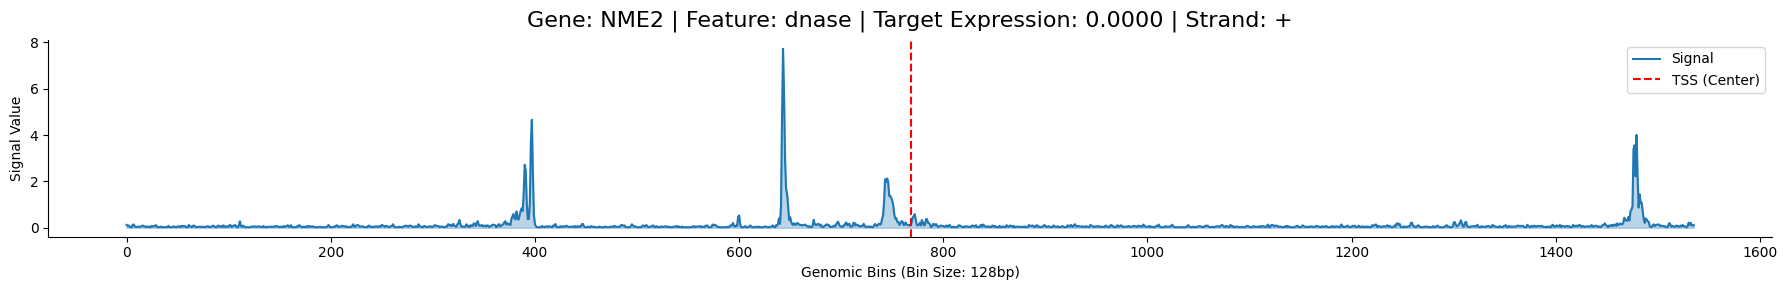

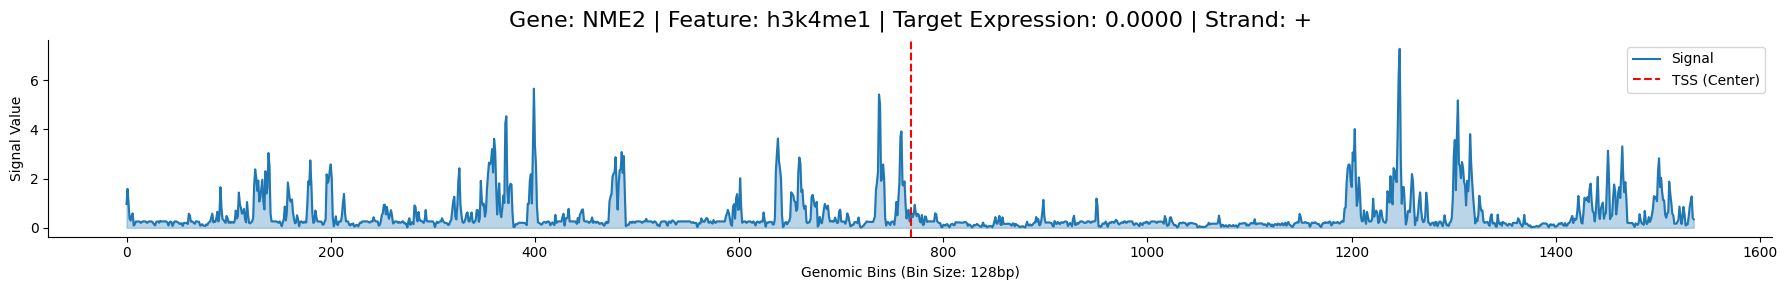

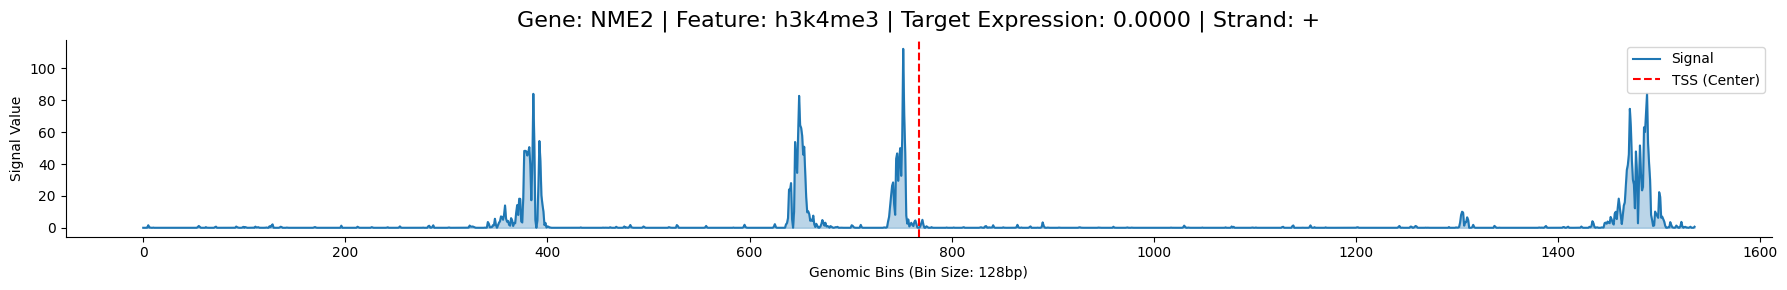

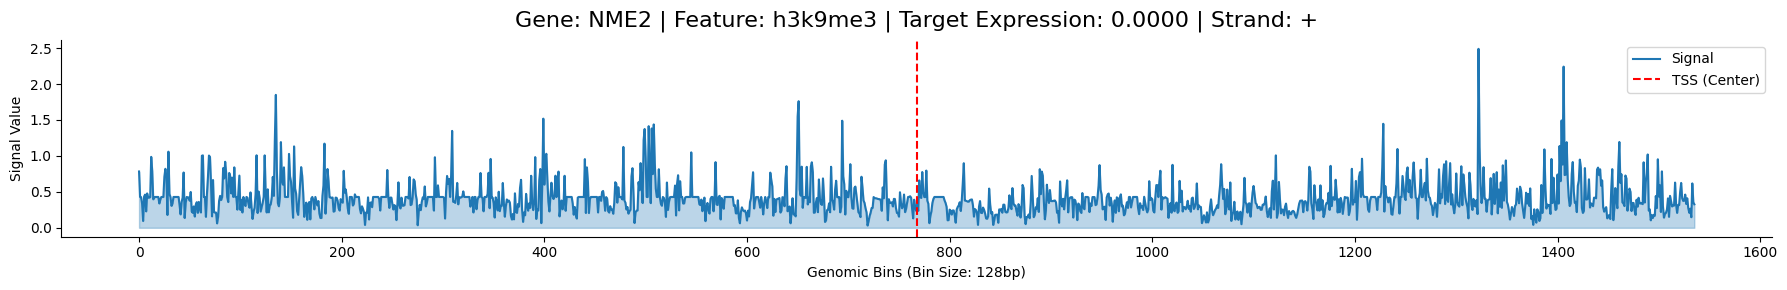

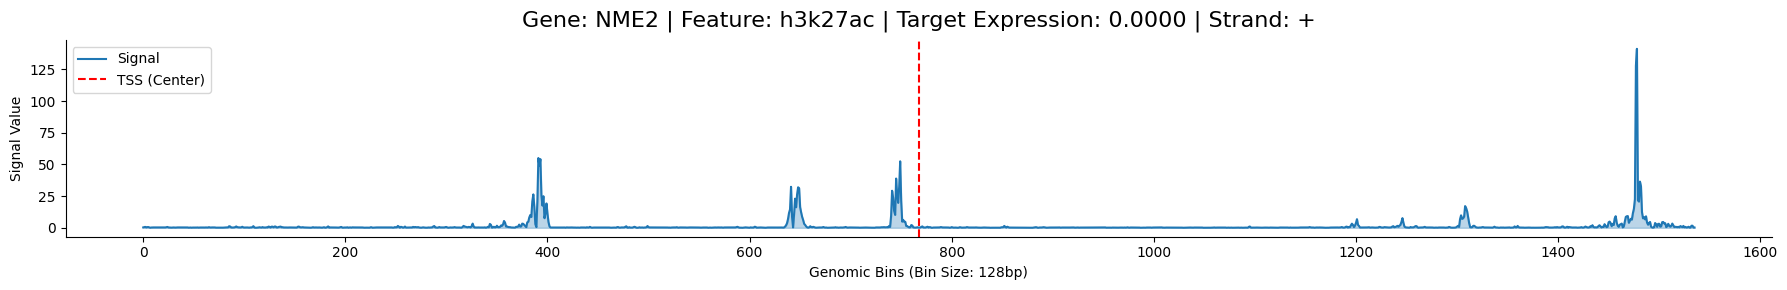

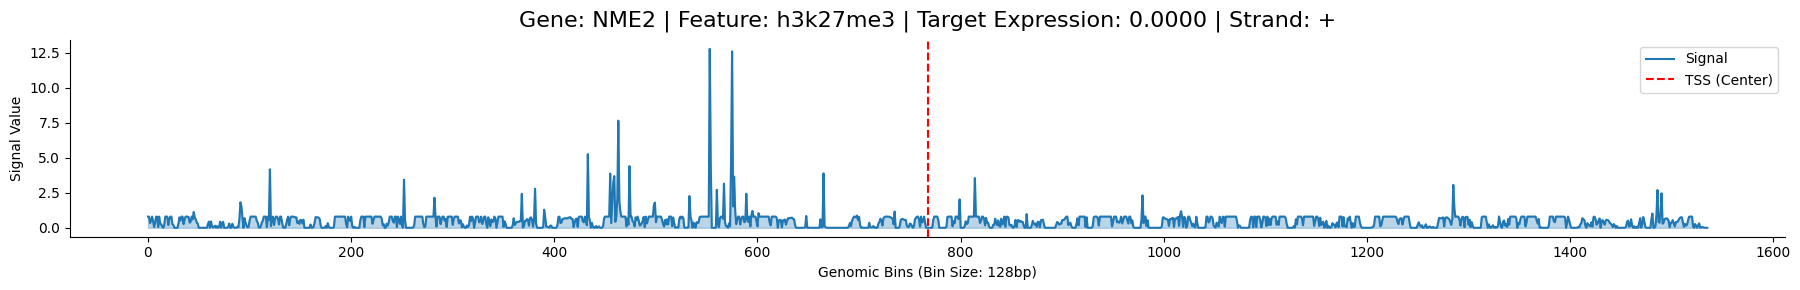

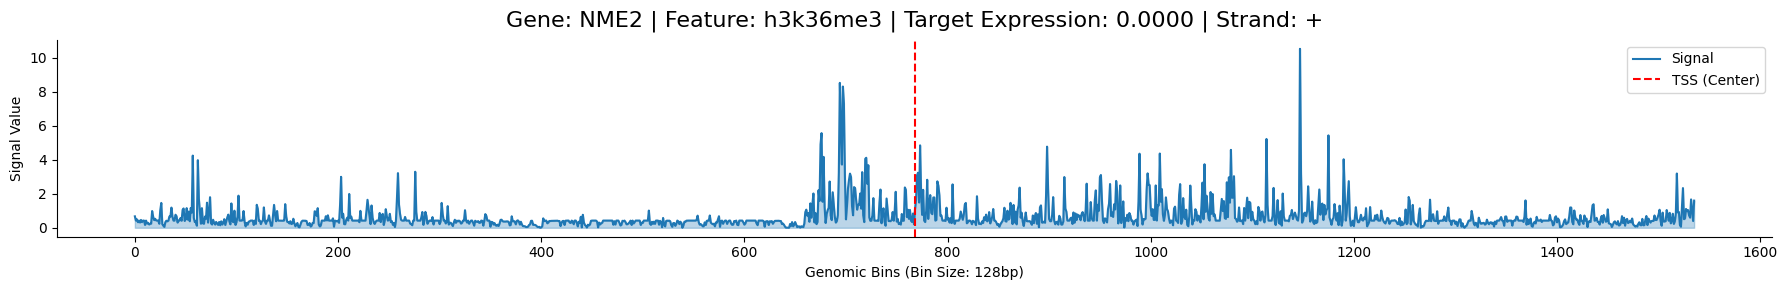

In [121]:
class FeatureNames(Enum):
    """Histone marks and chromatin accessibility features."""

    DNASE = "dnase"
    H3K4ME1 = "h3k4me1"
    H3K4ME3 = "h3k4me3"
    H3K9ME3 = "h3k9me3"
    H3K27AC = "h3k27ac"
    H3K27ME3 = "h3k27me3"
    H3K36ME3 = "h3k36me3"

def plot_single_feature_track(
    gene_data: SingleGeneData,
    feature_to_plot: str,
    bin_size: int = 128,
    figsize: tuple = (18, 3)
):
    """
    Plots a single feature track for a single gene.

    Args:
        gene_data: A SingleGeneData dictionary.
        feature_to_plot: The name of the single feature to plot (e.g., "h3k27ac").
        all_feature_names: The complete list of feature names in the
                           order they appear in the tensor.
        bin_size: The size of each genomic bin (e.g., 128) for labeling.
        figsize: The (width, height) of the matplotlib figure.
    """

    feature_name_list = [feature.value for feature in FeatureNames]
    feature_index = feature_name_list.index(feature_to_plot)

    signal_tensor = gene_data["sequence_tensor_slice"]

    signal_1d = signal_tensor[:, feature_index]

    n_bins = len(signal_1d)
    gene_name = gene_data["gene_info"]["gene_name"]
    target_val = gene_data["target"]
    strand = gene_data["gene_info"]["strand"]

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(signal_1d, color='C0', label="Signal")
    ax.fill_between(range(n_bins), signal_1d, color='C0', alpha=0.3)

    tss_bin_index = n_bins // 2
    ax.axvline(
        x=tss_bin_index,
        color='red',
        linestyle='--',
        linewidth=1.5,
        label="TSS (Center)"
    )

    ax.set_xlabel(f"Genomic Bins (Bin Size: {bin_size}bp)")
    ax.set_ylabel("Signal Value")
    ax.legend()
    ax.spines[['top', 'right']].set_visible(False)

    title = f"Gene: {gene_name} | Feature: {feature_to_plot}"
    title += f" | Target Expression: {target_val:.4f}"
    title += f" | Strand: {strand}"
    ax.set_title(title, fontsize=16, pad=10)

    plt.tight_layout()
    plt.show()

for feature in FeatureNames:
  plot_single_feature_track(
    gene_data=cell_line_x1.get_gene_data_by_index(6),
    feature_to_plot=feature.value,
    bin_size=cell_line_x1.bin_size
  )



In [122]:
def validate_combined_features(features: ProcessedFeatures):
    """Validates that all components of ProcessedFeatures are properly aligned."""
    print("\n" + "=" * 60)
    print("VALIDATING COMBINED FEATURES ALIGNMENT")
    print("=" * 60)

    n_genes = len(features.gene_annotations)
    gene_names = features.gene_annotations["gene_name"].values

    print(f"Number of genes: {n_genes}")
    print(f"Promoter tensor shape: {features.sequence_signal_tensor.shape}")
    print(f"Gene annotations shape: {features.gene_annotations.shape}")
    print(f"Has DNA features: {features.has_dna_features}")  # NEW
    if features.has_dna_features:
        n_features = features.sequence_signal_tensor.shape[2]
        print(f"Number of features: {n_features} (7 histone + 6 DNA)")
    print(
        f"Target expression shape: {features.target_expression.shape if features.target_expression is not None else 'None'}"
    )

    if features.sequence_signal_tensor.shape[0] != n_genes:
        print("ERROR: Promoter tensor length doesn't match gene annotations!")
        return False

    if features.target_expression is not None:
        if len(features.target_expression) != n_genes:
            print("ERROR: Target expression length doesn't match gene annotations!")
            return False

        target_genes = features.target_expression.index.values
        if not np.array_equal(gene_names, target_genes):
            print(
                "ERROR: Target expression index doesn't match gene_annotations order!"
            )
            print(f"  First 5 in annotations: {gene_names[:5]}")
            print(f"  First 5 in targets: {target_genes[:5]}")
            return False

    print("All alignments validated successfully!")
    print("=" * 60 + "\n")
    return True


def combine_cell_lines(
    cell_line_x1: ProcessedFeatures, cell_line_x2: ProcessedFeatures
) -> ProcessedFeatures:
    """
    Combines two ProcessedFeatures objects ensuring proper alignment.
    """
    print("\nCombining cell line features...")

    if cell_line_x1.has_dna_features != cell_line_x2.has_dna_features:
        raise ValueError(
            f"Cannot combine cell lines with different DNA feature status: "
            f"X1={cell_line_x1.has_dna_features}, X2={cell_line_x2.has_dna_features}"
        )

    combined_tensor = np.concatenate(
        [cell_line_x1.sequence_signal_tensor, cell_line_x2.sequence_signal_tensor],
        axis=0,
    )

    annotations_x1 = cell_line_x1.gene_annotations.copy()
    annotations_x2 = cell_line_x2.gene_annotations.copy()
    annotations_x1["gene_name"] = annotations_x1["gene_name"] + "_x1"
    annotations_x2["gene_name"] = annotations_x2["gene_name"] + "_x2"
    combined_annotations = pd.concat(
        [annotations_x1, annotations_x2], ignore_index=True
    )

    targets_x1 = cell_line_x1.target_expression.copy()
    targets_x2 = cell_line_x2.target_expression.copy()
    targets_x1.index = targets_x1.index + "_x1"
    targets_x2.index = targets_x2.index + "_x2"
    combined_targets = pd.concat([targets_x1, targets_x2])
    combined_targets = combined_targets.reindex(combined_annotations["gene_name"])

    combined_raw_sequences = None
    if cell_line_x1.raw_dna_sequences is not None and cell_line_x2.raw_dna_sequences is not None:
        combined_raw_sequences = np.concatenate(
            [cell_line_x1.raw_dna_sequences, cell_line_x2.raw_dna_sequences],
            axis=0
        )

    combined_features = ProcessedFeatures(
        gene_annotations=combined_annotations,
        sequence_signal_tensor=combined_tensor,
        window_size=cell_line_x1.window_size,
        bin_size=cell_line_x1.bin_size,
        n_bins=cell_line_x1.n_bins,
        target_expression=combined_targets,
        has_dna_features=cell_line_x1.has_dna_features,
        raw_dna_sequences=combined_raw_sequences
    )

    if not validate_combined_features(combined_features):
        raise ValueError("Combined features validation failed! Data is misaligned.")

    return combined_features


combined_features = combine_cell_lines(cell_line_x1, cell_line_x2)


Combining cell line features...

VALIDATING COMBINED FEATURES ALIGNMENT
Number of genes: 32568
Promoter tensor shape: (32568, 1536, 7)
Gene annotations shape: (32568, 7)
Has DNA features: False
Target expression shape: (32568,)
All alignments validated successfully!



In [144]:
@dataclass
class DataConfig:
    n_center_bins: int  # High-resolution bins at TSS (e.g., 64)
    flank_aggregation: int  # How many bins to aggregate in flanking regions (e.g., 16)'

@dataclass
class ModelConfig:
    """Hyperparameters for the model architecture."""
    n_features: int
    n_channels: int

    # Standard convolution channels
    conv_channels_1: int
    conv_channels_2: int
    conv_channels_3: int

    # Dilated convolution parameters
    use_dilated_conv: bool
    dilation_rates: tuple[int, ...]
    dilated_channels: int

    # Multi-scale ResNet parameters
    use_multiscale_resnet: bool
    resnet_large_kernel: int  # For coarse features
    resnet_small_kernel: int  # For fine features
    resnet_blocks: int  # Number of ResNet blocks

    # Group normalization
    res_groups_1: int
    res_groups_2: int
    res_groups_3: int

    # Prediction head
    head_dim_1: int
    head_dim_2: int

    # Dropout
    dropout_conv: float
    dropout_fc: float


@dataclass
class TrainConfig:
    checkpoint_dir: str
    device: torch.device
    hybrid_loss_alpha: float
    batch_size: int
    learning_rate: float
    weight_decay: float
    max_epochs: int
    num_workers: int
    patience: int
    min_delta: float
    monitor_name: str
    lr_t_0: int
    lr_t_mult: int
    lr_eta_min: float

@dataclass
class PathConfig:
    """Paths for saving models and checkpoints."""
    model_save_path: str

## Work Package 1.2 - Model Building

In [145]:
from dataclasses import dataclass
import torch
from torch.utils.data import Dataset
import numpy as np


class GeneExpressionDataset(Dataset):
    """
    PyTorch Dataset for gene expression prediction with multi-resolution binning.

    Strategy:
    - Center region (TSS): Keep high resolution (e.g., 64 bins × 128bp = 8kb)
    - Flanking regions: Aggregate bins for lower resolution (e.g., 16 bins → 1 coarse bin = 2048bp)

    This captures:
    - Fine-grained promoter features near TSS
    - Distant enhancer signals without massive parameter count
    """

    def __init__(
        self,
        processed_features: ProcessedFeatures,
        config: DataConfig,
        normalize_params=None,
        *,
        training: bool | None = None,
        validation: bool = False,
    ):
        """
        Args:
            processed_features: ProcessedFeatures object
            config: DataConfig with n_center_bins and flank_aggregation
            normalize_params: Optional dict with normalization params from training
            training: Explicit training-mode toggle
            validation: Explicit validation-mode toggle
        """
        # --- MODES ---
        is_training_inferred = normalize_params is None
        self.is_training = is_training if training is not None else is_training_inferred
        self.is_validation = bool(validation)

        requires_targets = processed_features.target_expression is not None
        if self.is_training and not requires_targets:
            raise ValueError("Target expression required for training dataset.")

        # --- INPUT TENSOR PROCESSING ---
        pt = torch.from_numpy(processed_features.sequence_signal_tensor).float()
        pt = pt.permute(0, 2, 1).contiguous()  # (N, F, B_original)
        N, F, B_original = pt.shape

        print(f"\n{'=' * 70}")
        print("MULTI-RESOLUTION BINNING")
        print(f"{'=' * 70}")
        print(f"Original bins: {B_original}")
        print(f"Original coverage: {B_original * 128:,}bp")

        # --- MULTI-RESOLUTION BINNING ---
        pt = self._create_multiscale_bins(
            pt,
            B_original,
            config.n_center_bins,
            config.flank_aggregation
        )

        N, F, B = pt.shape
        print(f"Final bins: {B}")
        print(f"{'=' * 70}\n")

        # --- APPLY ASINH TRANSFORM TO HISTONE FEATURES ---
        pt = torch.asinh(pt)

        if self.is_training and normalize_params is None:
            # --- TRAINING MODE: Compute normalization ---
            print("=" * 60)
            print("TRAINING MODE: Computing per-feature normalization")
            print("=" * 60)

            self.feature_means = pt.mean(dim=(0, 2))  # (F,)
            self.feature_stds = pt.std(dim=(0, 2))    # (F,)
            self.feature_stds[self.feature_stds < 1e-8] = 1e-8

            print(f"Computed stats for {F} features across {B} bins")

            # Target normalization
            target_values = processed_features.target_expression.fillna(0.0).values
            log_targets = np.log1p(target_values)

            self.target_log_mean = log_targets.mean()
            self.target_log_std = log_targets.std()

            normalized_targets = (log_targets - self.target_log_mean) / self.target_log_std
            self.targets = torch.from_numpy(normalized_targets).float()
            print(f"Target log1p mean: {self.target_log_mean:.3f}, std: {self.target_log_std:.3f}")
        else:
            # --- TEST/VAL MODE: Apply training normalization ---
            print("=" * 60)
            print("TEST/VAL MODE: Applying training normalization")
            print("=" * 60)

            self.feature_means = normalize_params["feature_means"]
            self.feature_stds = normalize_params["feature_stds"]
            self.target_log_mean = normalize_params["target_log_mean"]
            self.target_log_std = normalize_params["target_log_std"]

            self.targets = torch.zeros(N)

        # --- APPLY Z-SCORE NORMALIZATION ---
        mean_tensor = self.feature_means.unsqueeze(0).unsqueeze(2)  # (1, F, 1)
        std_tensor = self.feature_stds.unsqueeze(0).unsqueeze(2)    # (1, F, 1)
        pt = (pt - mean_tensor) / std_tensor

        self.promoter_tensor = pt
        print(f"Dataset size: {N} samples")
        print(f"Tensor shape: {tuple(self.promoter_tensor.shape)}")
        print("=" * 60 + "\n")

    def _create_multiscale_bins(
        self,
        tensor: torch.Tensor,
        B_original: int,
        n_center_bins: int,
        flank_aggregation: int
    ) -> torch.Tensor:
        """
        Create multi-resolution binning with fine center and coarse flanks.

        Args:
            tensor: Input tensor (N, F, B_original)
            B_original: Number of original bins
            n_center_bins: Number of fine-resolution bins to keep at center
            flank_aggregation: How many original bins to aggregate into one coarse bin

        Returns:
            Multi-resolution tensor (N, F, B_new) where:
            B_new = n_center_bins + 2 * (n_flank_coarse_bins)
        """
        N, F, _ = tensor.shape

        # Calculate center region
        center_start = (B_original - n_center_bins) // 2
        center_end = center_start + n_center_bins

        # Extract center bins (high resolution)
        center_bins = tensor[:, :, center_start:center_end]  # (N, F, n_center_bins)

        print(f"\nCenter bins ({n_center_bins}):")
        print(f"  Position: bins [{center_start}:{center_end}]")
        print(f"  Coverage: {n_center_bins * 128}bp at TSS")
        print(f"  Resolution: 128bp per bin")

        # Left flank aggregation
        left_flank = tensor[:, :, :center_start]  # (N, F, n_left)
        n_left = left_flank.shape[2]
        n_left_coarse = n_left // flank_aggregation

        if n_left_coarse > 0:
            # Reshape and average: (N, F, n_left_coarse, flank_aggregation) -> (N, F, n_left_coarse)
            left_bins_to_use = n_left_coarse * flank_aggregation
            left_flank_reshaped = left_flank[:, :, :left_bins_to_use].reshape(
                N, F, n_left_coarse, flank_aggregation
            )
            left_coarse = left_flank_reshaped.mean(dim=3)  # (N, F, n_left_coarse)
        else:
            left_coarse = torch.empty(N, F, 0)

        print(f"\nLeft flank ({n_left_coarse} coarse bins):")
        print(f"  Original bins: {n_left}")
        print(f"  Aggregation: {flank_aggregation} bins → 1 coarse bin")
        print(f"  Coverage: {n_left_coarse * flank_aggregation * 128:,}bp")
        print(f"  Resolution: {flank_aggregation * 128}bp per coarse bin")

        # Right flank aggregation
        right_flank = tensor[:, :, center_end:]  # (N, F, n_right)
        n_right = right_flank.shape[2]
        n_right_coarse = n_right // flank_aggregation

        if n_right_coarse > 0:
            right_bins_to_use = n_right_coarse * flank_aggregation
            right_flank_reshaped = right_flank[:, :, :right_bins_to_use].reshape(
                N, F, n_right_coarse, flank_aggregation
            )
            right_coarse = right_flank_reshaped.mean(dim=3)  # (N, F, n_right_coarse)
        else:
            right_coarse = torch.empty(N, F, 0)

        print(f"\nRight flank ({n_right_coarse} coarse bins):")
        print(f"  Original bins: {n_right}")
        print(f"  Aggregation: {flank_aggregation} bins → 1 coarse bin")
        print(f"  Coverage: {n_right_coarse * flank_aggregation * 128:,}bp")
        print(f"  Resolution: {flank_aggregation * 128}bp per coarse bin")

        # Concatenate: left_coarse + center + right_coarse
        multiscale_tensor = torch.cat([left_coarse, center_bins, right_coarse], dim=2)

        total_coverage = (
            n_left_coarse * flank_aggregation * 128 +
            n_center_bins * 128 +
            n_right_coarse * flank_aggregation * 128
        )

        print(f"\nMulti-resolution summary:")
        print(f"  Total bins: {multiscale_tensor.shape[2]}")
        print(f"  Total coverage: {total_coverage:,}bp ({total_coverage/1000:.1f}kb)")
        print(f"  Structure: [{n_left_coarse} coarse] + [{n_center_bins} fine] + [{n_right_coarse} coarse]")

        return multiscale_tensor

    def get_normalization_params(self):
        """Returns normalization parameters for use with test set."""
        return {
            "feature_means": self.feature_means,
            "feature_stds": self.feature_stds,
            "target_log_mean": self.target_log_mean,
            "target_log_std": self.target_log_std,
        }

    def denormalize_targets(self, normalized_predictions):
        """Converts normalized predictions back to original gene expression scale."""
        if torch.is_tensor(normalized_predictions):
            normalized_predictions = normalized_predictions.cpu().numpy()

        log_predictions = (normalized_predictions * self.target_log_std) + self.target_log_mean
        original_scale = np.expm1(log_predictions)
        return np.clip(original_scale, 0, None)

    def __len__(self) -> int:
        return len(self.targets)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Returns (features, target) for a single gene."""
        features = self.promoter_tensor[idx].clone()
        target = self.targets[idx]
        return features, target

class MultiScaleResBlock(nn.Module):
    """Multi-scale residual block with large and small kernels."""

    def __init__(self, channels: int, large_kernel: int, small_kernel: int, groups: int, dropout: float):
        super().__init__()

        # Large kernel path (coarse features)
        self.large_conv1 = nn.Conv1d(channels, channels, kernel_size=large_kernel, padding="same")
        self.large_norm1 = nn.GroupNorm(groups, channels)
        self.large_conv2 = nn.Conv1d(channels, channels, kernel_size=large_kernel, padding="same")
        self.large_norm2 = nn.GroupNorm(groups, channels)

        # Small kernel path (fine features)
        self.small_conv1 = nn.Conv1d(channels, channels, kernel_size=small_kernel, padding="same")
        self.small_norm1 = nn.GroupNorm(groups, channels)
        self.small_conv2 = nn.Conv1d(channels, channels, kernel_size=small_kernel, padding="same")
        self.small_norm2 = nn.GroupNorm(groups, channels)

        self.dropout = nn.Dropout(dropout)

        # Combine both paths
        self.combine = nn.Conv1d(channels * 2, channels, kernel_size=1)
        self.combine_norm = nn.GroupNorm(groups, channels)

    def forward(self, x):
        identity = x

        # Large kernel path
        large = F.relu(self.large_norm1(self.large_conv1(x)))
        large = self.large_norm2(self.large_conv2(large))
        large = self.dropout(large)

        # Small kernel path
        small = F.relu(self.small_norm1(self.small_conv1(x)))
        small = self.small_norm2(self.small_conv2(small))
        small = self.dropout(small)

        # Concatenate and combine
        combined = torch.cat([large, small], dim=1)
        out = self.combine_norm(self.combine(combined))

        # Residual connection
        out = out + identity
        return F.relu(out)


class DilatedConvBlock(nn.Module):
    """Multi-scale dilated convolution block."""

    def __init__(self, in_channels: int, out_channels: int, dilation_rates: tuple[int, ...]):
        super().__init__()

        # Create parallel dilated convolutions
        self.dilated_convs = nn.ModuleList([
            nn.Conv1d(
                in_channels,
                out_channels // len(dilation_rates),
                kernel_size=3,
                padding=dilation * (3 - 1) // 2,
                dilation=dilation
            )
            for dilation in dilation_rates
        ])

        self.norm = nn.GroupNorm(8, out_channels)

    def forward(self, x):
        outputs = [conv(x) for conv in self.dilated_convs]
        x = torch.cat(outputs, dim=1)
        x = self.norm(x)
        return F.relu(x)


class PromoterAttentionCNN(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        in_channels = config.n_features * config.n_channels

        # Initial conv
        self.conv1 = nn.Conv1d(in_channels, config.conv_channels_1, kernel_size=7, padding="same")
        self.norm1 = nn.GroupNorm(config.res_groups_1, config.conv_channels_1)
        self.dropout1 = nn.Dropout(config.dropout_conv)

        # Standard residual block 1
        self.res1_conv1 = nn.Conv1d(config.conv_channels_1, config.conv_channels_1, kernel_size=5, padding="same")
        self.res1_norm1 = nn.GroupNorm(config.res_groups_1, config.conv_channels_1)
        self.res1_conv2 = nn.Conv1d(config.conv_channels_1, config.conv_channels_1, kernel_size=5, padding="same")
        self.res1_norm2 = nn.GroupNorm(config.res_groups_1, config.conv_channels_1)
        self.pool1 = nn.MaxPool1d(2)

        # Dilated convolution branch (optional)
        if config.use_dilated_conv:
            self.dilated_block = DilatedConvBlock(
                config.conv_channels_1,
                config.dilated_channels,
                config.dilation_rates
            )
            conv2_in_channels = config.conv_channels_1 + config.dilated_channels
        else:
            self.dilated_block = None
            conv2_in_channels = config.conv_channels_1

        # Conv 2
        self.conv2 = nn.Conv1d(conv2_in_channels, config.conv_channels_2, kernel_size=5, padding="same")
        self.norm2 = nn.GroupNorm(config.res_groups_2, config.conv_channels_2)
        self.dropout2 = nn.Dropout(config.dropout_conv)

        # Standard residual block 2
        self.res2_conv1 = nn.Conv1d(config.conv_channels_2, config.conv_channels_2, kernel_size=3, padding="same")
        self.res2_norm1 = nn.GroupNorm(config.res_groups_2, config.conv_channels_2)
        self.res2_conv2 = nn.Conv1d(config.conv_channels_2, config.conv_channels_2, kernel_size=3, padding="same")
        self.res2_norm2 = nn.GroupNorm(config.res_groups_2, config.conv_channels_2)
        self.pool2 = nn.MaxPool1d(2)

        # Conv 3
        self.conv3 = nn.Conv1d(config.conv_channels_2, config.conv_channels_3, kernel_size=3, padding="same")
        self.norm3 = nn.GroupNorm(config.res_groups_3, config.conv_channels_3)
        self.dropout3 = nn.Dropout(config.dropout_conv)

        # Multi-scale ResNet blocks (optional)
        if config.use_multiscale_resnet:
            self.multiscale_blocks = nn.ModuleList([
                MultiScaleResBlock(
                    channels=config.conv_channels_3,
                    large_kernel=config.resnet_large_kernel,
                    small_kernel=config.resnet_small_kernel,
                    groups=config.res_groups_3,
                    dropout=config.dropout_conv
                )
                for _ in range(config.resnet_blocks)
            ])
        else:
            self.multiscale_blocks = None

        # Global average pooling
        self.gap = nn.AdaptiveAvgPool1d(1)

        # Prediction head
        self.fc1 = nn.Linear(config.conv_channels_3, config.head_dim_1)
        self.fc_norm = nn.LayerNorm(config.head_dim_1)
        self.fc_dropout = nn.Dropout(config.dropout_fc)
        self.fc2 = nn.Linear(config.head_dim_1, config.head_dim_2)
        self.fc_dropout2 = nn.Dropout(config.dropout_fc)
        self.fc3 = nn.Linear(config.head_dim_2, 1)

    def _residual_block(self, x, conv1, norm1, conv2, norm2):
        """Standard residual block with skip connection."""
        identity = x
        out = F.relu(norm1(conv1(x)))
        out = norm2(conv2(out))
        out += identity
        return F.relu(out)

    def forward(self, x):
        # Initial conv
        x = F.relu(self.norm1(self.conv1(x)))
        x = self.dropout1(x)

        # Residual block 1
        x = self._residual_block(
            x, self.res1_conv1, self.res1_norm1, self.res1_conv2, self.res1_norm2
        )
        x = self.pool1(x)

        # Dilated convolution branch
        if self.dilated_block is not None:
            dilated_features = self.dilated_block(x)
            x = torch.cat([x, dilated_features], dim=1)

        # Conv 2
        x = F.relu(self.norm2(self.conv2(x)))
        x = self.dropout2(x)

        # Residual block 2
        x = self._residual_block(
            x, self.res2_conv1, self.res2_norm1, self.res2_conv2, self.res2_norm2
        )
        x = self.pool2(x)

        # Conv 3
        x = F.relu(self.norm3(self.conv3(x)))
        x = self.dropout3(x)

        # Multi-scale ResNet blocks
        if self.multiscale_blocks is not None:
            for block in self.multiscale_blocks:
                x = block(x)

        # Global average pooling
        x = self.gap(x).squeeze(-1)  # (batch, conv_channels_3)

        # Prediction head
        h = F.relu(self.fc_norm(self.fc1(x)))
        h = self.fc_dropout(h)
        h = F.relu(self.fc2(h))
        h = self.fc_dropout2(h)
        return self.fc3(h).squeeze(1)

In [146]:
def spearman_epoch_scorer(net, dataset_valid, y=None):
    """
    Custom skorch scorer to calculate Spearman correlation on the validation set.
    """
    y_pred = net.predict(dataset_valid).ravel()
    y_true = np.array([y_i.item() for _, y_i in dataset_valid]).ravel()

    correlation, _ = spearmanr(y_true, y_pred)

    if np.isnan(correlation):
        return 0.0

    return float(correlation)


def validate_dataset(dataset):
    """Validates dataset for NaN, Inf, and prints value ranges."""
    print("\n=== Data Validation ===")

    has_nan = torch.isnan(dataset.promoter_tensor).any()
    has_inf = torch.isinf(dataset.promoter_tensor).any()
    print(f"Promoter - NaN: {has_nan}, Inf: {has_inf}")
    print(
        f"Promoter range: [{dataset.promoter_tensor.min():.3f}, {dataset.promoter_tensor.max():.3f}]"
    )

    has_nan = torch.isnan(dataset.targets).any()
    has_inf = torch.isinf(dataset.targets).any()
    print(f"Targets - NaN: {has_nan}, Inf: {has_inf}")
    print(f"Targets range: [{dataset.targets.min():.3f}, {dataset.targets.max():.3f}]")
    print(
        f"Targets with value 0.0: {(dataset.targets == 0.0).sum()} / {len(dataset.targets)}"
    )
    print("=====================\n")

class HybridLoss(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
    def forward(self, y_pred, y_true):
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        mse = F.mse_loss(y_pred, y_true)
        y_pred_centered = y_pred - torch.mean(y_pred)
        y_true_centered = y_true - torch.mean(y_true)
        numerator = torch.sum(y_pred_centered * y_true_centered)
        denominator = (torch.sqrt(torch.sum(y_pred_centered**2)) * torch.sqrt(torch.sum(y_true_centered**2)) + 1e-8)
        pearson = numerator / denominator
        return self.alpha * mse + (1 - self.alpha) * (1 - pearson)

def train_with_skorch(
    full_ds: Dataset,
    model: nn.Module,
    *,
    config: TrainConfig
):
    N = len(full_ds)
    indices = list(range(N))
    train_idx, val_idx = train_test_split(indices, test_size=0.1, random_state=42)

    train_ds = Subset(full_ds, train_idx)
    valid_ds = Subset(full_ds, val_idx)

    pin_memory = config.device.type == "cuda"
    callbacks = [
        EpochScoring(
            spearman_epoch_scorer,
            lower_is_better=False,
            name=config.monitor_name,
            use_caching=False,
        ),
        EarlyStopping(
            monitor=config.monitor_name,
            patience=config.patience,
            threshold=config.min_delta,
            lower_is_better=False,
        ),
        Checkpoint(
            dirname=config.checkpoint_dir,
            monitor=f"{config.monitor_name}_best",
            f_params="best_model.pt",
        ),
        LRScheduler(
            policy=CosineAnnealingWarmRestarts,
            T_0=config.lr_t_0,
            T_mult=config.lr_t_mult,
            eta_min=config.lr_eta_min,
        ),
    ]

    net = NeuralNetRegressor(
        model,
        criterion=HybridLoss(alpha=config.hybrid_loss_alpha),
        criterion__alpha=config.hybrid_loss_alpha,
        optimizer=optim.AdamW,
        optimizer__lr=config.learning_rate,
        optimizer__weight_decay=config.weight_decay,
        max_epochs=config.max_epochs,
        batch_size=config.batch_size,
        device=config.device.type,
        train_split=predefined_split(valid_ds),
        callbacks=callbacks,
        iterator_train__num_workers=config.num_workers,
        iterator_valid__num_workers=config.num_workers,
        iterator_train__pin_memory=pin_memory,
        iterator_valid__pin_memory=pin_memory,
    )

    print(f"Combined dataset size: {N}")
    print(f"Training set size:   {len(train_idx)}")
    print(f"Validation set size: {len(val_idx)}")

    net.fit(train_ds, y=None)

    net.load_params(f_params=Path(config.checkpoint_dir) / "best_model.pt")
    best_torch_model = net.module_
    return net, best_torch_model

In [150]:
data_config = DataConfig(
    n_center_bins=64,      # 64 × 128bp = 8kb at TSS (high res)
    flank_aggregation=128,  # 16 × 128bp = 2kb per coarse bin
)

model_config = ModelConfig(
    n_features=7,
    n_channels=1,

    conv_channels_1=48,
    conv_channels_2=96,
    conv_channels_3=128,

    use_dilated_conv=False,
    dilation_rates=(1,),
    dilated_channels=0,

    use_multiscale_resnet=True,
    resnet_large_kernel=11,
    resnet_small_kernel=3,
    resnet_blocks=1,

    res_groups_1=8,
    res_groups_2=8,
    res_groups_3=8,

    head_dim_1=256,   # Was 384
    head_dim_2=96,    # Was 128

    dropout_conv=0.25,  # Increase regularization
    dropout_fc=0.25,
)

train_config = TrainConfig(
    checkpoint_dir="checkpoints",
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    hybrid_loss_alpha=0.2,  # 0.5*MSE + 0.5*(1-Pearson)
    batch_size=256,
    learning_rate=3e-4,
    weight_decay=5e-4,
    max_epochs=100,
    num_workers=2,
    patience=10,
    min_delta=1e-4,
    monitor_name="valid_spearman",
    lr_t_0=10,
    lr_t_mult=2,
    lr_eta_min=1e-6,
)

path_config = PathConfig(
    model_save_path="./best_model/best_model.pth",
)

print(f"Using device: {train_config.device}")
print("Creating dataset...")
full_ds = GeneExpressionDataset(
    processed_features=combined_features,
    config=data_config,
)
validate_dataset(full_ds)

model = PromoterAttentionCNN(
    config=model_config
)

print("Starting training...")
net, best_model = train_with_skorch(
    full_ds=full_ds,
    model=model,
    config=train_config
)

# --- 5. Save Final Model ---
torch.save(best_model.state_dict(), path_config.model_save_path)
print(f"\nSaved best model to: {path_config.model_save_path}")

Using device: cuda
Creating dataset...

MULTI-RESOLUTION BINNING
Original bins: 1536
Original coverage: 196,608bp

Center bins (64):
  Position: bins [736:800]
  Coverage: 8192bp at TSS
  Resolution: 128bp per bin

Left flank (5 coarse bins):
  Original bins: 736
  Aggregation: 128 bins → 1 coarse bin
  Coverage: 81,920bp
  Resolution: 16384bp per coarse bin

Right flank (5 coarse bins):
  Original bins: 736
  Aggregation: 128 bins → 1 coarse bin
  Coverage: 81,920bp
  Resolution: 16384bp per coarse bin

Multi-resolution summary:
  Total bins: 74
  Total coverage: 172,032bp (172.0kb)
  Structure: [5 coarse] + [64 fine] + [5 coarse]
Final bins: 74

TRAINING MODE: Computing per-feature normalization
Computed stats for 7 features across 74 bins
Target log1p mean: 1.256, std: 1.925
Dataset size: 32568 samples
Tensor shape: (32568, 7, 74)


=== Data Validation ===
Promoter - NaN: False, Inf: False
Promoter range: [-1.097, 14.643]
Targets - NaN: False, Inf: False
Targets range: [-0.653, 4.48

## Work Package 1.3 - Prediction on Test Data (Evaluation Metric)

In [96]:
pred = None
test_genes = cell_line_x3.gene_annotations["gene_name"].values

print(f"\nPredicting on {len(test_genes)} test genes\n")

# Create training dataset (computes normalization)
print("Step 1: Loading training data and computing normalization...")
train_ds = GeneExpressionDataset(combined_features)

# Get normalization params
norm_params = train_ds.get_normalization_params()

# Create test dataset (applies training normalization)
print("\nStep 2: Creating test dataset with training normalization...")
test_ds = GeneExpressionDataset(cell_line_x3, normalize_params=norm_params)

# Create and load model
print("\nStep 3: Loading trained model...")
model = PromoterAttentionCNN(
    n_bins=combined_features.n_bins,
    n_features=7,
    n_channels=1,
)

net = NeuralNetRegressor(
    model,
    device=DEVICE.type,
)

net.initialize()
net.load_params(
    f_params="/workspaces/Gene-Expression-Prediction/src/gene_expression_prediction/checkpoints_promoter_only/best_model.pt"
)

# Predict (returns normalized predictions)
print("\nStep 4: Making predictions...")
pred_normalized = net.predict(test_ds)

# Denormalize back to original scale
print("\nStep 5: Denormalizing predictions...")
pred = train_ds.denormalize_targets(pred_normalized)

# Summary
print(f"\n{'=' * 60}")
print("PREDICTION SUMMARY")
print(f"{'=' * 60}")
print(f"  Shape: {pred.shape}")
print(f"  Range: [{pred.min():.3f}, {pred.max():.3f}]")
print(f"  Mean:  {pred.mean():.3f}")
print(f"  Median: {np.median(pred):.3f}")
print(f"{'=' * 60}\n")

# Validation
assert isinstance(pred, np.ndarray), "Prediction must be numpy array"
assert np.issubdtype(pred.dtype, np.number), "Prediction must be numeric"
assert pred.shape[0] == len(test_genes), "One prediction per gene"
assert not np.isnan(pred).any(), "No NaN values"
assert not np.isinf(pred).any(), "No Inf values"


Predicting on 1984 test genes

Step 1: Loading training data and computing normalization...


TypeError: GeneExpressionDataset.__init__() missing 1 required positional argument: 'config'

#### Store Predictions in the Required Format

In [ ]:
# Store predictions in a ZIP.
# Upload this zip on the project website under "Your submission".
# Zip this notebook along with the conda environment (and README, optional) and upload this under "Your code".
save_dir = "/workspaces/Gene-Expression-Prediction/data/output"
file_name = "gex_predicted.csv"  # PLEASE DO NOT CHANGE THIS
zip_name = "Tokar_David_Project1.zip"
save_path = f"{save_dir}/{zip_name}"
compression_options = {"method": "zip", "archive_name": file_name}

submission_df = pd.DataFrame({"gene_name": test_genes, "gex_predicted": pred})

compression_options = {"method": "zip", "archive_name": file_name}

submission_df.to_csv(save_path, index=False, compression=compression_options)
print(f"File saved to: {save_path}")
print("\nPreview of the first 5 rows of the submission file:")
print(submission_df.head())